## Decision tree classifier

In [1]:
import numpy as np
import os
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

# Load the numpy .npz file
with np.load(os.path.join('data', 'cifar4-train.npz'), allow_pickle=False) as data:
    cifar4_data = dict(data.items())
    
print('Data loaded')
print('It is a dictionary with keys:', list(cifar4_data.keys()))

Data loaded
It is a dictionary with keys: ['pixels', 'overfeat', 'labels', 'names', 'allow_pickle']


In [2]:
X = cifar4_data['overfeat']
y = cifar4_data['labels']

print('X shape:',X.shape)
print('y shape:', y.shape)

X shape: (5000, 4096)
y shape: (5000,)


In [3]:
from sklearn.decomposition import PCA

# PCA to reduce dimensions. 
# Using 164 as this is the result from the previous exercise ensuring 90% of PVE explained
pca = PCA(n_components=164)
X = pca.fit_transform(X)
print('X shape:',X.shape)

X shape: (5000, 164)


From the data exploration we use 164 features and we apply it to the data set.

In [7]:
# Splitting the data
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=4000,test_size=1000,
                                          random_state=0, stratify=y)
# Split train data again
X_train_s, X_val, y_train_s, y_val = train_test_split(X_train, y_train,train_size=3200,test_size=800,
                                          random_state=0, stratify=y_train)

# checking the shapes
print('X_train:', X_train.shape, X_train.dtype)
print('y_train:', y_train.shape, y_train.dtype)
print('X_train_s:', X_train_s.shape, X_train_s.dtype)
print('y_train_s:', y_train_s.shape, y_train_s.dtype)
print('X_val:', X_val.shape, X_val.dtype)
print('y_val:', y_val.shape, y_val.dtype)
print('X_test:', X_test.shape, X_test.dtype)
print('y_test:', y_test.shape, y_test.dtype)

X_train: (4000, 164) float32
y_train: (4000,) int64
X_train_s: (3200, 164) float32
y_train_s: (3200,) int64
X_val: (800, 164) float32
y_val: (800,) int64
X_test: (1000, 164) float32
y_test: (1000,) int64


In [8]:
from sklearn.tree import DecisionTreeClassifier

# Create decision tree 
dt = DecisionTreeClassifier(criterion='gini', max_depth=1, random_state=0)

# Fit decision tree
dt.fit(X_train_s,y_train_s)

# Get score
dt.score(X_val,y_val)

0.4475

Deeper depth with grid search

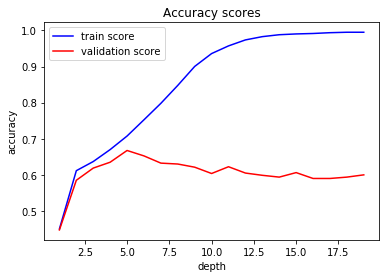

In [23]:
# Define a set of reasonable values
depth_values = np.arange(1,20,1)

# Save accuracy on validation set
train_scores = []
validation_scores = []

# Grid search
for depth in depth_values:
    dt = DecisionTreeClassifier(criterion='gini', max_depth=depth, random_state=0)
    dt.fit(X_train_s,y_train_s)
    
    # Accuracy
    accuracy_train = dt.score(X_train_s,y_train_s)
    accuracy_val = dt.score(X_val,y_val)
    
    
    # Save train accuracy
    train_scores.append({
        'depth': depth,
        'accuracy': accuracy_train
    })

    
    # Save validation accuracy
    validation_scores.append({
        'depth': depth,
        'accuracy': accuracy_val
    })


# Create DataFrame with train scores
train_scores_df = pd.DataFrame(train_scores)    
    
# Create DataFrame with validation scores
val_scores_df = pd.DataFrame(validation_scores)

# Plot train and validation curve
plt.plot(train_scores_df['depth'],train_scores_df['accuracy'], color='blue',label='train score')
plt.plot(val_scores_df['depth'],val_scores_df['accuracy'], color='red',label='validation score')
plt.title('Accuracy scores')
plt.xlabel('depth')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [32]:
# Best combination
idx_max = val_scores_df.loc[val_scores_df['accuracy'].idxmax()]

print('Top accuracy on validation set:',idx_max[0],
      ' with depth:',idx_max[1])

Top accuracy on validation set: 0.6675  with depth: 5.0


When we increase the complexity of the tree with its depth, we are overfitting. It is with a depth level of 5 we got the highest accuracy on the validation set - 67%.
This reflects one of the main issues with decision trees, small trees are too simple (high bias) to model our data and larger ones tend to overfit (high variance).

In [33]:
# Fitting the tuned estimators on the entire train set
dt = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=0)
dt.fit(X_train,y_train)
dt.score(X_test, y_test)

0.66

Using the entire data set we get a 66% accuracy.

## Random forest classifier

In [35]:
n_trees = np.arange(50,201,50)
print(n_trees)

[ 50 100 150 200]


In [37]:
from sklearn.ensemble import RandomForestClassifier

# Define a set of reasonable values
n_trees = np.arange(50,401,50)

# Save accuracy on validation set

validation_scores = []

# Grid search
for ensemble in n_trees:
    rf = RandomForestClassifier(n_estimators=ensemble, max_depth=None, random_state=0 )
    rf.fit(X_train_s,y_train_s)
    
    # Accuracy
    accuracy_val = rf.score(X_val,y_val)
    
    # Save validation accuracy
    validation_scores.append({
        'n estimators': ensemble,
        'validation accuracy': accuracy_val
    })
    
# Create DataFrame with validation scores
val_scores_df = pd.DataFrame(validation_scores)

val_scores_df.head(10)

,n estimators,validation accuracy
0,50,0.73625
1,100,0.75625
2,150,0.76625
3,200,0.76500
4,250,0.78375


In [39]:
# Best combination
idx_max = val_scores_df.loc[val_scores_df['validation accuracy'].idxmax()]

print('Top accuracy on validation set:',idx_max[1],
      ' with n estimators:',idx_max[0])

Top accuracy on validation set: 0.78375  with n estimators: 250.0


Using the entire train set:

In [40]:
# Fitting the tuned estimators on the entire train set
rf = RandomForestClassifier(n_estimators=250, max_depth=None, random_state=0 )
rf.fit(X_train,y_train)
rf.score(X_test, y_test)

0.764

Accuracy values

In [41]:
print('Decision tree accuracy (test set): 66%')
print('Random forest accuracy (test set): 76%')

Decision tree accuracy (test set): 66%
Random forest accuracy (test set): 76%
